In [1]:
# Import libraries

# File manipulation

import os # For working with Operating System
import requests # Accessing the Web
import datetime as dt # Working with dates/times
import io # Input/Output Bytes objects
import time # For sleep in for loop

# Analysis

import numpy as np
import pandas as pd
import arcpy
import statsmodels.api as sm # This is for the regression. Please "pip install statsmodels" as it is not in the base environment

import matplotlib.pyplot as plt
# import seaborn as sns

# # important as it "enhances" Pandas by importing these classes
# from arcgis.features import GeoAccessor, GeoSeriesAccessor

In [2]:
# Load Csv's 

cwd = os.getcwd()

data_path = os.path.join(cwd,'..', '..', 'data')

modeling_df = pd.read_csv(os.path.join(data_path, 'Parameter_df.csv'))

modeling_df['date'] = pd.to_datetime(modeling_df.date)

In [3]:
modeling_df.head()

,sensor_index,date,is_weekday,n_observations,pm25_fullDay_mean,pm25_fullDay_minutesAbove12ug,n_spikes,humidity_fullDay_mean,temperature_fullDay_mean,pressure_fullDay_mean,idwSum_facilities,idwSum_traffic
0,143656,2023-03-18,0,144,5.341125,190,0,45.833,23.505,988.205,0.005054,861.930809
1,142774,2022-11-05,0,144,8.901722,370,0,62.438,42.682,973.451,0.004609,452.986261
2,145454,2022-12-06,1,144,11.355750,690,2,48.174,26.181,987.556,67.350629,587.483355
3,142748,2022-12-07,1,144,11.848437,560,3,53.589,25.477,994.330,2.827060,3827.349398
4,143636,2023-01-22,0,144,24.739590,1440,50,60.596,28.776,983.963,24.669941,453.501189


In [4]:
modeling_df.date.dt.date

0        2023-03-18
1        2022-11-05
2        2022-12-06
3        2022-12-07
4        2023-01-22
            ...    
10367    2023-01-15
10368    2023-01-08
10369    2022-06-26
10370    2023-03-09
10371    2022-10-23
Name: date, Length: 10372, dtype: object

In [5]:
# Get previous day

previous_dates = modeling_df.date.dt.date - dt.timedelta(1)

for i, row in modeling_df.iterrows():
    
    previous_date = previous_dates.loc[i]
    
    sensor_id = row.sensor_index
    
    previous_readings = modeling_df[(modeling_df.date.dt.date == previous_date)&
                                   (modeling_df.sensor_index == sensor_id)].pm25_fullDay_mean
    
    if len(previous_readings) == 1:

        modeling_df.loc[i, 'pm25_fullDay_mean_yesterday'] = previous_readings.iloc[0]

    
modeling_df.head()

,sensor_index,date,is_weekday,n_observations,pm25_fullDay_mean,pm25_fullDay_minutesAbove12ug,n_spikes,humidity_fullDay_mean,temperature_fullDay_mean,pressure_fullDay_mean,idwSum_facilities,idwSum_traffic,pm25_fullDay_mean_yesterday
0,143656,2023-03-18,0,144,5.341125,190,0,45.833,23.505,988.205,0.005054,861.930809,4.240750
1,142774,2022-11-05,0,144,8.901722,370,0,62.438,42.682,973.451,0.004609,452.986261,13.551993
2,145454,2022-12-06,1,144,11.355750,690,2,48.174,26.181,987.556,67.350629,587.483355,8.880667
3,142748,2022-12-07,1,144,11.848437,560,3,53.589,25.477,994.330,2.827060,3827.349398,7.053014
4,143636,2023-01-22,0,144,24.739590,1440,50,60.596,28.776,983.963,24.669941,453.501189,13.688465


In [6]:
no_nans = modeling_df.dropna()

print(len(no_nans), len(modeling_df))

9857 10372


In [7]:
no_nans.sensor_index.unique()

array([143656, 142774, 145454, 142748, 143636, 156605, 145498, 143666,
       143226, 143942, 143240, 143916, 142718, 142720, 142734, 143214,
       145506, 142726, 142744, 142730, 142752, 143668, 142732, 145242,
       157787, 143648, 142756, 142728, 143224, 143238, 143246, 145616,
       143944, 157935, 157837, 145470, 145250, 143242, 168327, 145202,
       145604, 142736, 145204, 157747, 157757, 157871, 157785, 142724,
       157845, 157861, 166459, 157877, 142738, 142750], dtype=int64)

In [8]:
no_nans.date.dt.month.unique()

array([ 3, 11, 12,  1, 10,  2,  4,  6,  7,  9,  8], dtype=int64)

In [16]:
y = no_nans.pm25_fullDay_mean

x_names = ['humidity_fullDay_mean', 'pm25_fullDay_mean_yesterday',
           'temperature_fullDay_mean', 'pressure_fullDay_mean',
           # 'idwSum_facilities', 'idwSum_traffic'
    ]
X = no_nans[x_names]

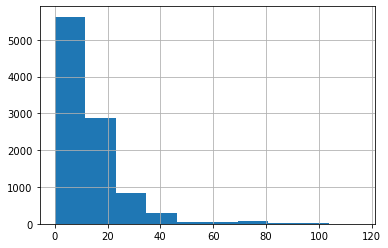

<AxesSubplot:>

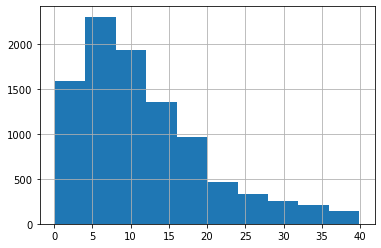

In [17]:
# Check out distributions

# for column in x_names:
#     print(column)
#     no_nans[column].hist()
#     plt.show()

y.hist()
plt.show()
y[y<40].hist()

<AxesSubplot:>

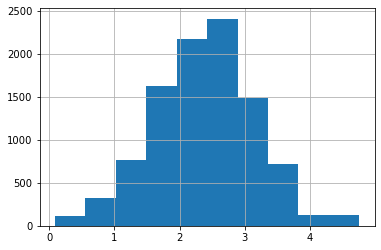

In [18]:
# Oooh, we should log this?

new_y = np.log(y+1)

new_y.hist()

In [19]:
# Try OLS?

X = sm.add_constant(X.values) # Need to add a constant to make it work
model = sm.OLS(new_y.values,X)
results = model.fit()
results.params

array([ 3.70568948e+00,  7.23889182e-03,  2.99991903e-02,  1.72477090e-03,
       -2.21371931e-03])

In [20]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     1030.
Date:                Tue, 02 May 2023   Prob (F-statistic):               0.00
Time:                        15:02:34   Log-Likelihood:                -9698.6
No. Observations:                9857   AIC:                         1.941e+04
Df Residuals:                    9852   BIC:                         1.944e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7057      0.768      4.825      0.000       2.200       5.211
x1             0.0072      0.001      9.814      0.000       0.006       0.009
x2             0.0300      0.001     58.038      0.000       0.029       0.031
x3             0.0017      0.000      5.129      0.000       0.001       0.002
x4            -0.0022      0.001     -2.914      0.004      -0.004      -0.001
==============================================================================
Omnibus:                      347.293   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              384.182
Skew:                          -0.481   Prob(JB):                     3.77e-84
Kurtosis:                       3.106   Cond. No.                     1.16e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [106]:
plot_df = no_nans.copy()

plot_df['predicted'] = m1.predy

[Text(0.5, 0, 'Observed'), Text(0, 0.5, 'Predicted')]

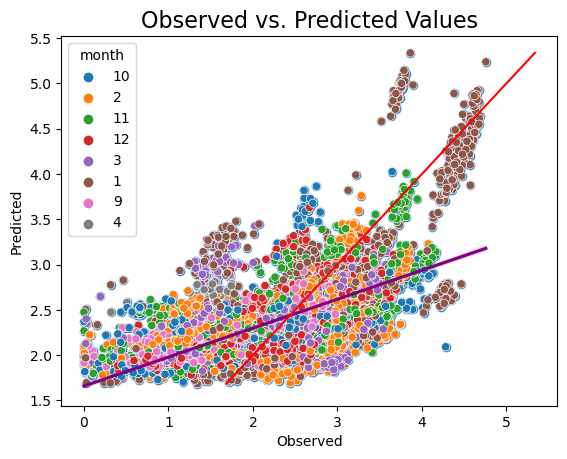

In [107]:
# Compare Observed and Predicted values
# Hue by month

plot_df = no_nans.copy()

plot_df['observed'] = new_y
plot_df['predicted'] = m1.predy
plot_df['month'] = plot_df.date.dt.month.astype(str)
plot_df['sensor_index_plot'] = plot_df.sensor_index.astype(str)

# initialize plot
f,ax=plt.subplots(1)


sns.regplot(x = new_y.values,
            y = plot_df['predicted'].values,
            # color = no_nans.sensor_index,
            line_kws = {'color':'purple'},
            
            ax = ax) # scatterplot fit = purple

sns.scatterplot(data = plot_df,
                x = 'observed',
            y = 'predicted',
            hue = 'month',
            # line_kws = {'color':'purple'},
            
            ax = ax) # scatterplot fit = purple

plt.plot([min(m1.predy), max(m1.predy)], [min(m1.predy),max(m1.predy)], color = 'r') # perfect fit = red

ax.set_title('Observed vs. Predicted Values', fontsize=16) # Set Title

ax.set(xlabel='Observed', ylabel='Predicted') # Set Labels

[Text(0.5, 0, 'Observed'), Text(0, 0.5, 'Predicted')]

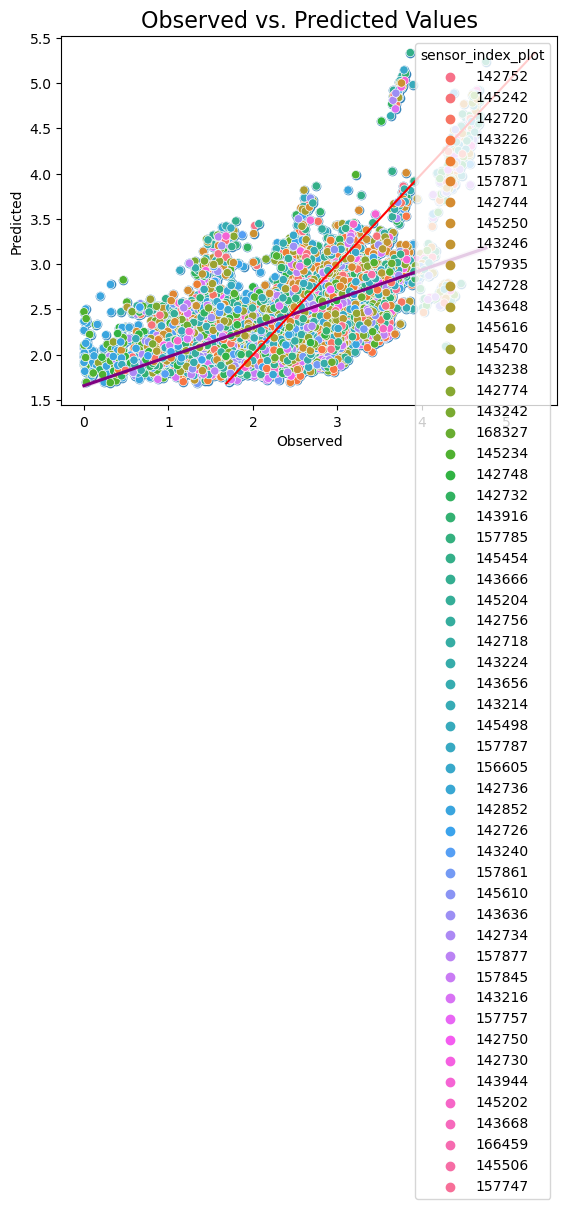

In [108]:
# Hue by sensor index

# initialize plot
f,ax=plt.subplots(1)


sns.regplot(x = plot_df['observed'].values,
            y = plot_df['predicted'].values,
            # color = no_nans.sensor_index,
            line_kws = {'color':'purple'},
            
            ax = ax) # scatterplot fit = purple

sns.scatterplot(data = plot_df,
                x = 'observed',
            y = 'predicted',
            hue = 'sensor_index_plot',
            # line_kws = {'color':'purple'},
            
            ax = ax) # scatterplot fit = purple

plt.plot([min(m1.predy), max(m1.predy)], [min(m1.predy),max(m1.predy)], color = 'r') # perfect fit = red

ax.set_title('Observed vs. Predicted Values', fontsize=16) # Set Title

ax.set(xlabel='Observed', ylabel='Predicted') # Set Labels